<a href="https://colab.research.google.com/github/xli2522/simple-BBH-waveform/blob/main/simple_BBH_waveform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -- Uncomment following line if running in Google Colab
! pip install -q 'gwpy==1.0.1'

     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 51 kB 2.6 MB/s 
     |████████████████████████████████| 55 kB 1.7 MB/s 
     |████████████████████████████████| 3.6 MB 38.7 MB/s 


In [26]:
%matplotlib inline
import gwpy
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt


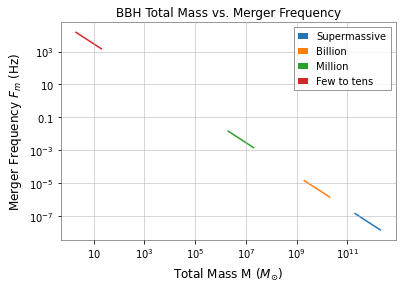

[[1.4604595344127507e-07, 1.460459534412751e-08], [1.4604595344127508e-05, 1.4604595344127509e-06], [0.014604595344127507, 0.001460459534412751], [14604.595344127509, 1460.4595344127508]]


In [27]:
# Frequency ranges of BBH mergers
def fmerger(M):
    '''Calculates the merger freuqency of a BBH system given the total mass M of the system

    '''
    c = 3*10**8
    G = 6.674*10**(-11)
    R = 1.7
    freq = (2*c**3)/(R**(3/2)*G*M*1.989*10**30)/(2*np.pi)

    return freq

# Calculate the frequency ranges of 
ranges = []; masses = []
# 1. Supermassive 10**11 Msolar
Mmin = 2*10**11; Mmax = 2*10**12
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 2. Billion Msolar
Mmin = 2*10**9; Mmax = 2*10**10
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 3. Million Msolar
Mmin = 2*10**6; Mmax = 2*10**7
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 4. Few to tens Msolar
Mmin = 2; Mmax = 20
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])

for i in range(len(ranges)):
    plt.plot(masses[i], ranges[i])
plt.legend(['Supermassive', 'Billion','Million', 'Few to tens'])
plt.title('BBH Total Mass vs. Merger Frequency')
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r'Total Mass M ($M_{\odot}$)')
plt.ylabel(r'Merger Frequency $F_m$ (Hz)')
plt.show()

print(ranges)

### Obtain GW150914 Data from LIGO Database

In [25]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = 1126259446 
print("GW150914 Starting GPS:", gps)

ldata = TimeSeries.fetch_open_data('L1', gps, gps+32, cache=True)
hdata = TimeSeries.fetch_open_data('H1', gps, gps+32, cache=True)
print(ldata)

GW150914 Starting GPS: 1126259446
TimeSeries([-1.04289994e-18, -1.03586274e-18, -9.89322445e-19,
            ..., -1.01767748e-18, -9.82876816e-19,
            -9.59276974e-19]
           unit: dimensionless,
           t0: 1126259446.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


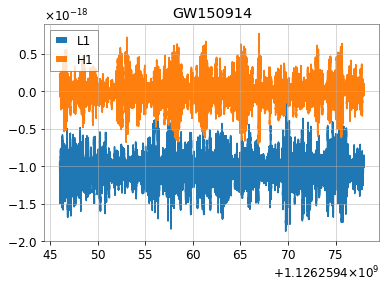

131072


In [24]:
plt.plot(ldata)
plt.plot(hdata)
plt.legend(['L1','H1'])
plt.title('GW150914')
plt.show()

print(len(ldata))